In [1]:
import pandas as pd
from scipy import stats
import datetime
from sklearn.metrics import mean_squared_error
import rpy2
import random
import math
import seaborn as sns
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("import/ecs_series_1_uid_encoded(1).csv")

In [7]:
datetime_object = datetime.datetime.strptime("9/27/18 16:00", "%m/%d/%y %H:%M")
df['Date'] = df["ds"].apply(lambda x:datetime.datetime.strptime(x, "%m/%d/%y %H:%M"))
df = df.drop(columns = ['ds','region_no_factor','iz_no_factor','product_factor','instance_type_name_factor','instance_type_family_factor'])

In [8]:
df = df.groupby(by=['uid','Date']).sum().reset_index()
df = df.pivot(columns = 'Date',index = 'uid',values = 'vcpu_net_delead')

In [10]:
df_2000 = pd.read_csv("export/alibaba/alibaba_initial_time_series_2000.csv")
#df_2000 = df.sample(2000)

## Theta method

In [11]:
from rpy2.robjects.packages import importr
# import R's "base" package
# import rpy2's package module
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list
# R package names
packnames = ['forecast']
# R vector of strings
from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector('forecast'))
base = importr('forecast')


In [12]:
# Theta just skips nan
df_2000 = df_2000.applymap(lambda x:float(0.0) if (np.isnan(x)) else x)

### We take test as last 10 weeks (70 days)

In [13]:
df_2000_train= df_2000.iloc[:,0:len(df_2000.columns)-70]
df_2000_true= df_2000.iloc[:,len(df_2000_train.columns):len(df_2000.columns)]
df_2000_true.insert(0,'uid',df_2000['uid'])

df_2000_train = df_2000_train.set_index('uid')
df_2000_true=df_2000_true.set_index('uid')

In [14]:
df_prediction = pd.DataFrame(columns = df_2000_true.columns)
for index, row in df_2000_train.iterrows():
    res = robjects.FloatVector(row.drop(columns = ['uid']))
    r_prediction = base.thetaf(res,70)[1]
    df_prediction.loc[index] = r_prediction

In [15]:
math.sqrt(mean_squared_error(df_2000_true,df_prediction))

0.03571373602016229

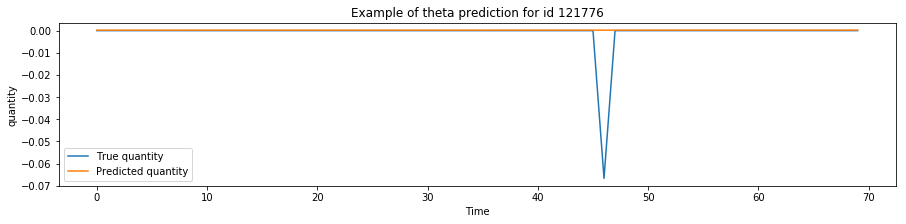

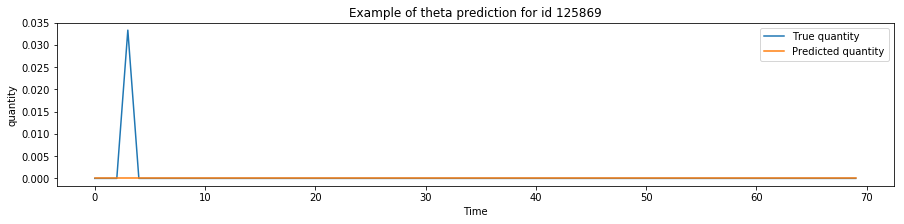

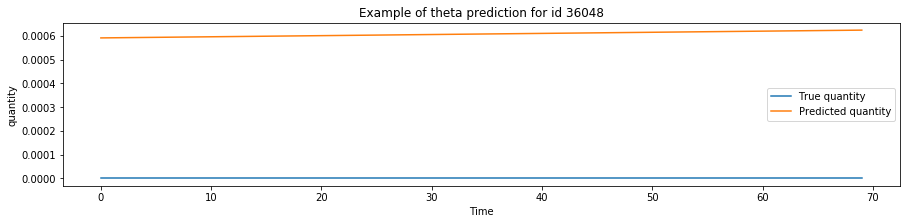

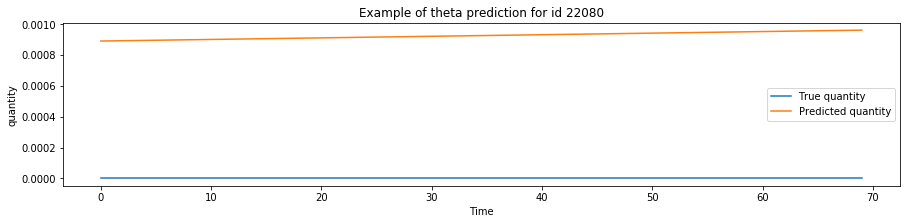

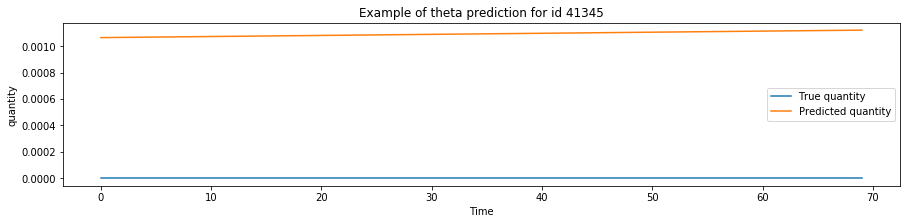

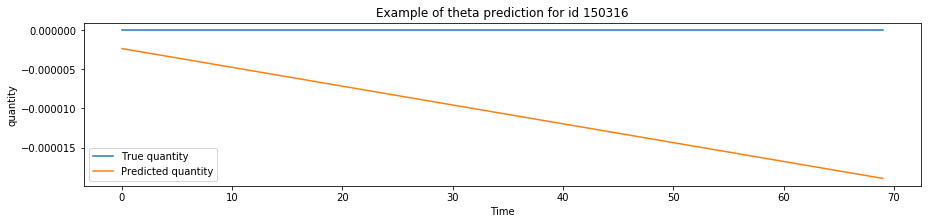

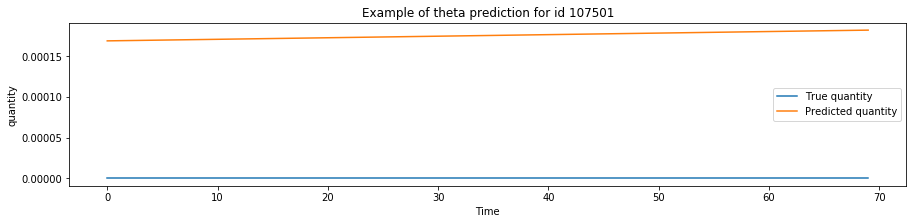

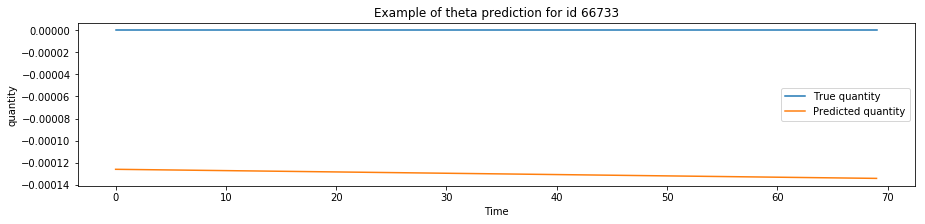

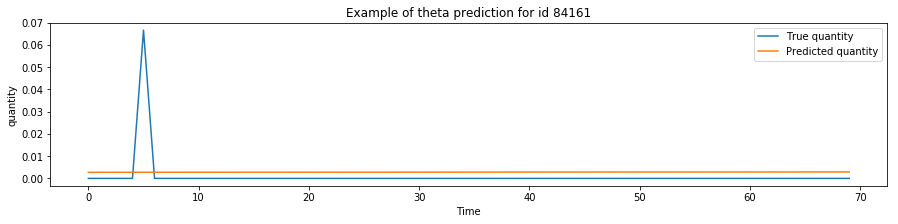

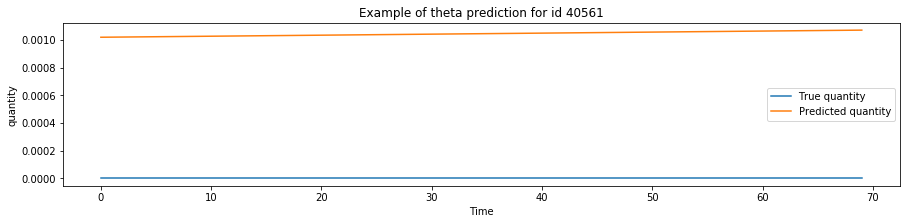

In [17]:
for x in range(10):
    rand = random.choice (df_2000_true.index)
    fig = plt.figure(figsize=(15,3))
    plt.plot(np.array(df_2000_true.loc[rand,:]).ravel(), label = 'True quantity')
    plt.plot(np.array(df_prediction.loc[rand,:]).ravel(), label = 'Predicted quantity')
    plt.xlabel('Time')
    plt.ylabel('quantity')
    plt.title('Example of theta prediction for id '+str(rand))
    plt.legend(); 